In [1]:
# HelpDesk — Event Log EDA (days)
# Explore: schema, activities, cases, durations, next-time deltas, variants, DFG pairs, timelines.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
PATH = "/ceph/lfertig/Thesis/data/processed/df_helpdesk.csv.gz"
CASE_COL = "case:concept:name"
ACT_COL  = "concept:name"
TIME_COL = "time:timestamp"

In [4]:
df = pd.read_csv(PATH, low_memory=False)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.info()
display(df.head(25))

Shape: (21348, 5)
Columns: ['case:concept:name', 'concept:name', 'time:timestamp', '@@index', '@@case_index']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21348 entries, 0 to 21347
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   case:concept:name  21348 non-null  object
 1   concept:name       21348 non-null  object
 2   time:timestamp     21348 non-null  object
 3   @@index            21348 non-null  int64 
 4   @@case_index       21348 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 834.0+ KB


,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,Case 1,Assign seriousness,2012-10-09 14:50:17+00:00,0,0
1,Case 1,Take in charge ticket,2012-10-09 14:51:01+00:00,1,0
2,Case 1,Take in charge ticket,2012-10-12 15:02:56+00:00,2,0
3,Case 1,Resolve ticket,2012-10-25 11:54:26+00:00,3,0
4,Case 1,Closed,2012-11-09 12:54:39+00:00,4,0
5,Case 10,Assign seriousness,2010-02-10 08:50:20+00:00,5,1
6,Case 10,Take in charge ticket,2010-03-19 08:47:06+00:00,6,1
7,Case 10,Resolve ticket,2010-03-19 08:47:13+00:00,7,1
8,Case 10,Closed,2010-04-03 07:47:38+00:00,8,1
9,Case 100,Assign seriousness,2013-04-12 10:25:17+00:00,9,2


In [5]:
# Parse timestamps, basic sanity checks, sort
assert CASE_COL in df.columns and ACT_COL in df.columns and TIME_COL in df.columns, "Expected columns missing."
df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True, errors="coerce")
assert df[TIME_COL].notna().any(), "All timestamps are NaT—check the time column."
df = df.sort_values([CASE_COL, TIME_COL]).reset_index(drop=True)

# High-level counts
n_events = len(df)
n_cases  = df[CASE_COL].nunique()
n_acts   = df[ACT_COL].nunique()
print(f"Events: {n_events:,} | Cases: {n_cases:,} | Activities: {n_acts:,}")

Events: 21,348 | Cases: 4,580 | Activities: 14


,count,mean,std,min,50%,90%,95%,99%,max
events_per_case,4580.0,4.661135,1.180026,2.0,4.0,6.0,7.0,9.0,15.0


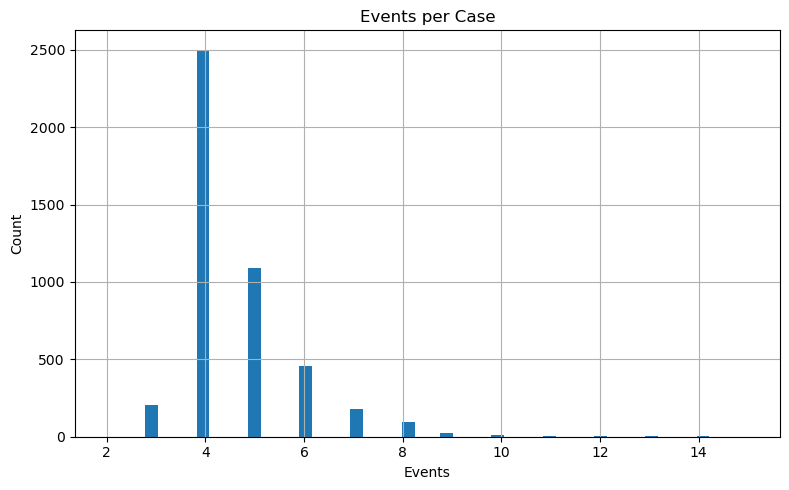

In [6]:
# Events per case
ev_per_case = df.groupby(CASE_COL, sort=False).size().rename("events_per_case")
ev_stats = ev_per_case.describe(percentiles=[0.5, 0.9, 0.95, 0.99])
display(ev_stats.to_frame().T)

plt.figure(figsize=(8,5))
plt.hist(ev_per_case, bins=50)
plt.title("Events per Case"); plt.xlabel("Events"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); plt.show()

,count,mean,std,min,50%,90%,95%,99%,max
case_duration_days,4580.0,40.858408,8.38675,30.641817,39.859219,53.005646,57.976652,59.047493,59.994965


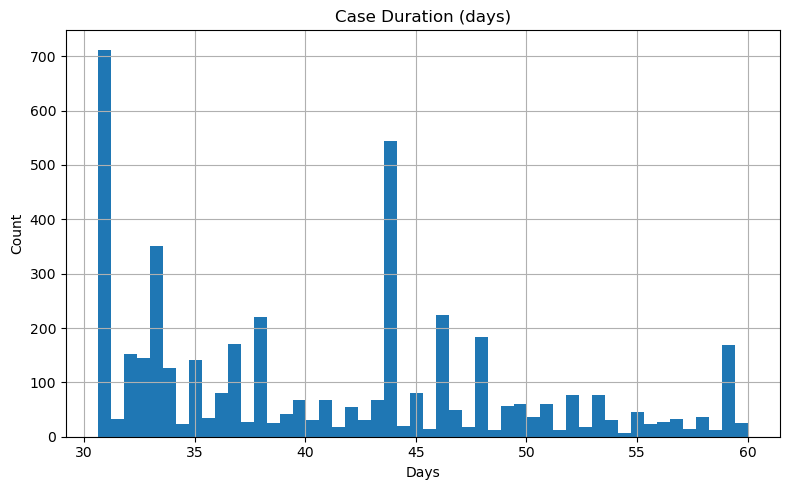

,days
case:concept:name,
Case 2628,59.994965
Case 353,59.986100
Case 2400,59.981030
Case 2137,59.967986
Case 940,59.966863
Case 2798,59.964931
Case 3901,59.961806
Case 1307,59.938032
Case 973,59.928484


,days
case:concept:name,
Case 170,30.641817
Case 821,30.652245
Case 3766,30.666343
Case 447,30.667639
Case 856,30.680069
Case 2201,30.681389
Case 4069,30.681887
Case 2330,30.682257
Case 169,30.692778


In [7]:
# Case durations (days): end - start per case
g = df.groupby(CASE_COL, sort=False)[TIME_COL]
case_start = g.min()
case_end   = g.max()
case_duration_days = (case_end - case_start).dt.total_seconds() / 86400.0
dur_stats = case_duration_days.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).rename("case_duration_days")
display(dur_stats.to_frame().T)

plt.figure(figsize=(8,5))
plt.hist(case_duration_days, bins=50)
plt.title("Case Duration (days)"); plt.xlabel("Days"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); plt.show()

# Top/bottom cases by duration
display(case_duration_days.sort_values(ascending=False).head(10).to_frame("days"))
display(case_duration_days.sort_values(ascending=True).head(10).to_frame("days"))

,count,mean,std,min,50%,90%,95%,99%,max
next_time_delta_days,16768.0,11.160037,14.428883,0.0,3.27897,34.018319,43.229098,52.229917,59.958912


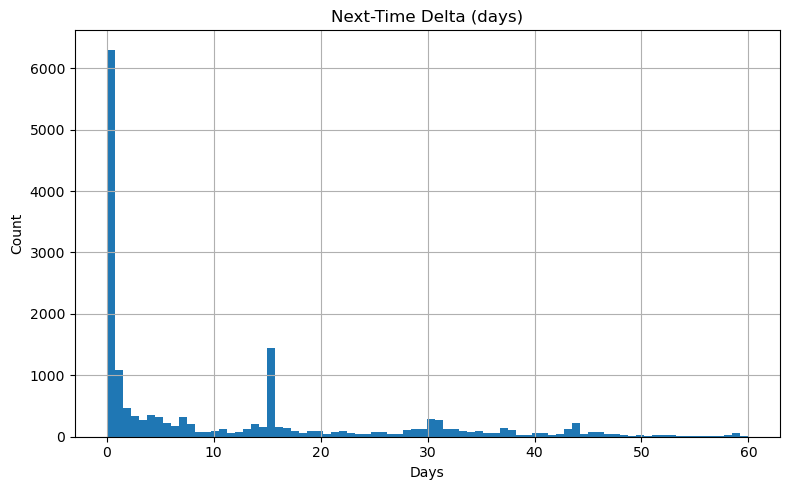

In [8]:
# Next-time deltas (days): within-case differences between consecutive events
df["next_time_delta_days"] = (
    df.groupby(CASE_COL, sort=False)[TIME_COL]
      .diff()
      .dt.total_seconds() / 86400.0
)
ntd = df["next_time_delta_days"].dropna()
ntd_stats = ntd.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).rename("next_time_delta_days")
display(ntd_stats.to_frame().T)

plt.figure(figsize=(8,5))
plt.hist(ntd, bins=80)
plt.title("Next-Time Delta (days)"); plt.xlabel("Days"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); plt.show()

,case_starts
concept:name,
Assign seriousness,4384
Insert ticket,118
Take in charge ticket,74
Resolve ticket,2
Create SW anomaly,1
Wait,1


,case_ends
concept:name,
Closed,4557
Resolve ticket,10
Wait,8
Require upgrade,3
VERIFIED,1
Take in charge ticket,1


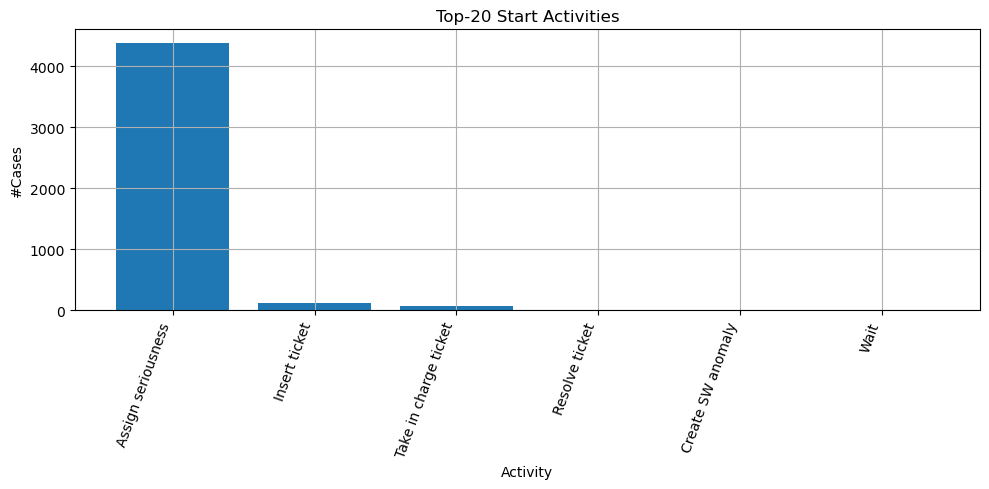

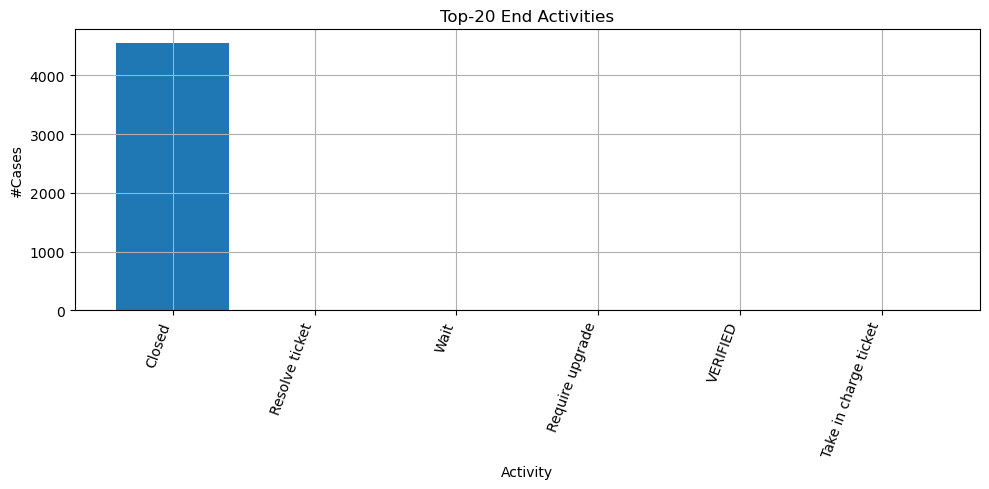

In [9]:
# Start/End activities
first_acts = df.groupby(CASE_COL, sort=False).first()[ACT_COL].value_counts()
last_acts  = df.groupby(CASE_COL, sort=False).last()[ACT_COL].value_counts()
display(first_acts.head(20).to_frame("case_starts"))
display(last_acts.head(20).to_frame("case_ends"))

plt.figure(figsize=(10,5))
plt.bar(first_acts.head(20).index.astype(str), first_acts.head(20).values)
plt.title("Top-20 Start Activities"); plt.xlabel("Activity"); plt.ylabel("#Cases")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.bar(last_acts.head(20).index.astype(str), last_acts.head(20).values)
plt.title("Top-20 End Activities"); plt.xlabel("Activity"); plt.ylabel("#Cases")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

,from,to,count
0,Resolve ticket,Closed,4558
1,Assign seriousness,Take in charge ticket,4160
2,Take in charge ticket,Resolve ticket,3563
3,Take in charge ticket,Wait,1265
4,Wait,Resolve ticket,773
5,Wait,Take in charge ticket,558
6,Assign seriousness,Assign seriousness,439
7,Assign seriousness,Resolve ticket,258
8,Resolve ticket,Resolve ticket,254
9,Resolve ticket,Take in charge ticket,154


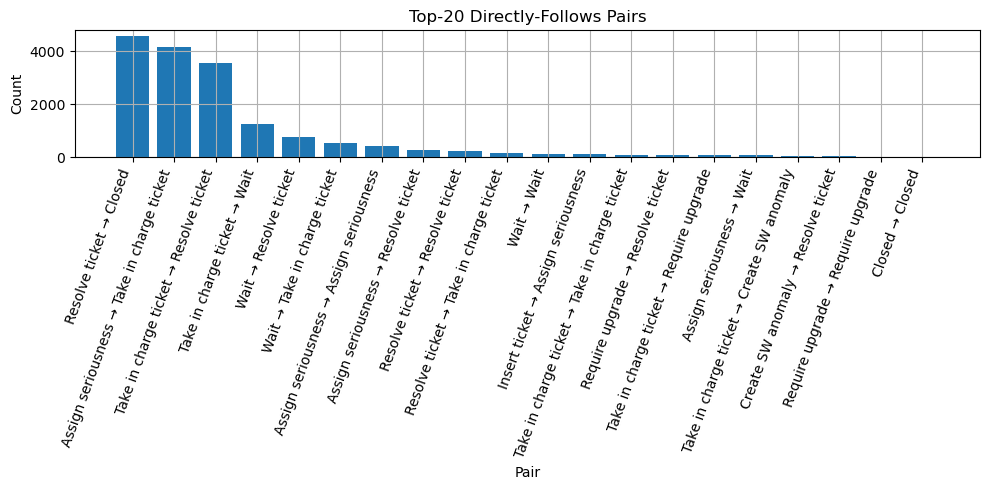

In [10]:
# Directly-Follows Graph (DFG) counts: bigrams within cases
def dfg_counts(df, case_col, act_col):
    pairs = []
    for _, g in df.groupby(case_col, sort=False):
        acts = g[act_col].dropna().tolist()
        if len(acts) > 1:
            pairs.extend(zip(acts[:-1], acts[1:]))

    s = pd.Series(pairs)
    vc = s.value_counts()  # index: tuples like ('A','B'), values: counts

    # Make it a MultiIndex so we can name the levels and reset cleanly
    vc.index = pd.MultiIndex.from_tuples(vc.index, names=["from", "to"])
    dfg_df = vc.reset_index(name="count")
    return dfg_df

dfg_df = dfg_counts(df, CASE_COL, ACT_COL)
display(dfg_df.head(20))

plt.figure(figsize=(10,5))
top_pairs = dfg_df.head(20)
labels = [f"{a} \u2192 {b}" for a, b in zip(top_pairs["from"], top_pairs["to"])]
plt.bar(labels, top_pairs["count"].values)
plt.title("Top-20 Directly-Follows Pairs"); plt.xlabel("Pair"); plt.ylabel("Count")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

/tmp/ipykernel_3996520/3733048281.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(case_variant)


,count,cumulative_coverage
Assign seriousness → Take in charge ticket → Resolve ticket → Closed,2366,0.516594
Assign seriousness → Take in charge ticket → Wait → Resolve ticket → Closed,552,0.637118
Assign seriousness → Take in charge ticket → Wait → Take in charge ticket → Resolve ticket → Closed,228,0.686900
Assign seriousness → Assign seriousness → Take in charge ticket → Resolve ticket → Closed,213,0.733406
Assign seriousness → Resolve ticket → Closed,164,0.769214
Assign seriousness → Take in charge ticket → Resolve ticket → Resolve ticket → Closed,109,0.793013
Insert ticket → Assign seriousness → Take in charge ticket → Resolve ticket → Closed,69,0.808079
Assign seriousness → Resolve ticket → Resolve ticket → Closed,62,0.821616
Assign seriousness → Take in charge ticket → Resolve ticket → Take in charge ticket → Resolve ticket → Closed,48,0.832096
Assign seriousness → Take in charge ticket → Require upgrade → Resolve ticket → Closed,40,0.840830


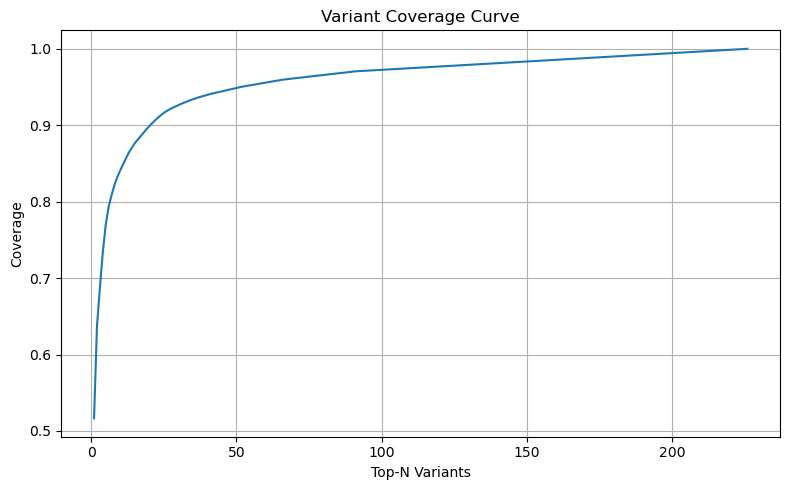

In [11]:
# Variants (activity sequences per case)
def case_variant(g):
    return " → ".join(g[ACT_COL].tolist())

variants = (
    df.groupby(CASE_COL, sort=False)
      .apply(case_variant)
      .value_counts()
)
coverage = (variants.cumsum() / variants.sum()).rename("cumulative_coverage")
top_variants = pd.concat([variants.rename("count"), coverage], axis=1).head(20)
display(top_variants)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(coverage)+1), coverage.values)
plt.title("Variant Coverage Curve"); plt.xlabel("Top-N Variants"); plt.ylabel("Coverage")
plt.grid(True); plt.tight_layout(); plt.show()

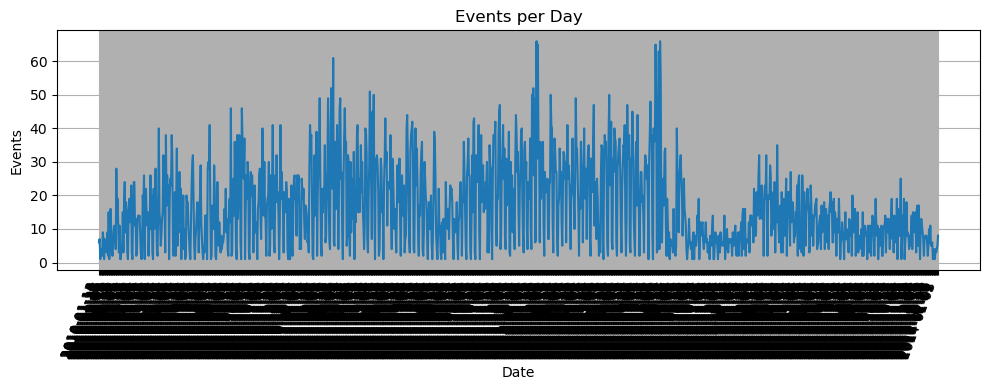

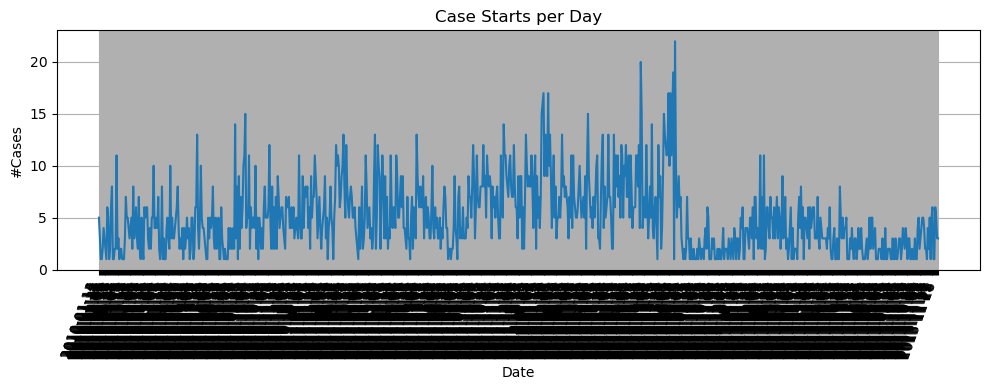

In [12]:
# Timeline views (event counts per day; case starts per day)
df["event_date"] = df[TIME_COL].dt.tz_convert(None).dt.date
events_per_day = pd.Series(df["event_date"]).value_counts().sort_index()
plt.figure(figsize=(10,4))
plt.plot(events_per_day.index.astype(str), events_per_day.values)
plt.title("Events per Day"); plt.xlabel("Date"); plt.ylabel("Events")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

case_start_date = case_start.dt.tz_convert(None).dt.date
starts_per_day = case_start_date.value_counts().sort_index()
plt.figure(figsize=(10,4))
plt.plot(starts_per_day.index.astype(str), starts_per_day.values)
plt.title("Case Starts per Day"); plt.xlabel("Date"); plt.ylabel("#Cases")
plt.xticks(rotation=70, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

In [13]:
# Missing values overview
na = df.isna().sum().sort_values(ascending=False)
display(na.to_frame("n_missing").T)

,next_time_delta_days,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,event_date
n_missing,4580,0,0,0,0,0,0


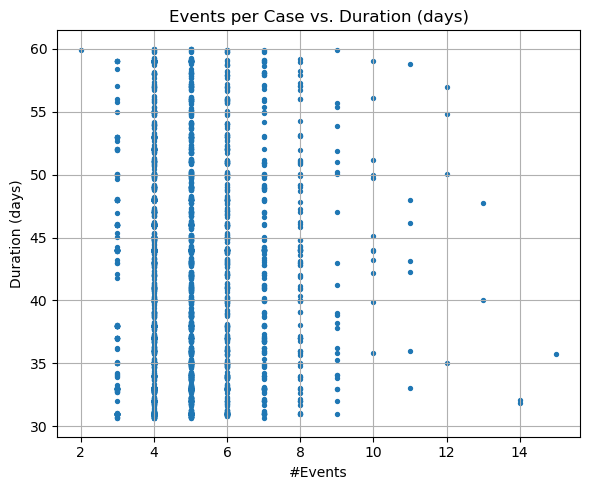

In [14]:
# Correlate events-per-case vs. duration (days) (quick scatter in matplotlib)
aligned = pd.DataFrame({
    "events_per_case": ev_per_case,
    "duration_days": case_duration_days
}).dropna()

plt.figure(figsize=(6,5))
plt.scatter(aligned["events_per_case"], aligned["duration_days"], s=8)
plt.title("Events per Case vs. Duration (days)")
plt.xlabel("#Events"); plt.ylabel("Duration (days)")
plt.grid(True); plt.tight_layout(); plt.show()

In [15]:
print("EDA complete.")

EDA complete.
